никнейм на kaggle: dmitrysidimekov

team name на kaggle: Дмитрий_Сидимеков_448193375

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

11.1.0


Получение данных через kaggle

In [102]:
# from google.colab import userdata
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [103]:
!kaggle competitions download -c journey-springfield

"kaggle" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [104]:
!unzip -q ./journey-springfield.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [105]:
!ls train

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 12 19:05:23 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.92       Driver Version: 528.92       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P5     8W /  85W |    107MiB /  8188MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle # модуль для сохранения и загрузки бинарных файлов, в основном моделей, предобработанных данных и тд
import numpy as np
from skimage import io # загрузка и сохранение изображений

from tqdm import tqdm, tqdm_notebook # прогресс бар для циклов, в ноутбуке в том числе
from PIL import Image # модуль для работы и обработкой изображений
from pathlib import Path # работа с путями файлов и папок

from torchvision import models, transforms # трансформации датасетов (даталоадер, аугментация, скейлинг и тд)
from multiprocessing.pool import ThreadPool #
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# логгер для TensorBoard
from torch.utils.tensorboard import SummaryWriter


from matplotlib import colors, pyplot as plt
# показывать графики без plt.show()
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = /frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [6]:

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file) # self.label_encoder.transform['класс'] даст индекс именованной метки

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load() # загружает пиксели в память
        return image

    def __getitem__(self, index):
        # перенесём аугментации в train чтобы были на gpu
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # Добавим аугментации
        # if (self.mode == 'train'):
        #   transform = transforms.Compose([
        #       transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        #       transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2, hue=0.1),
        #       transforms.RandomHorizontalFlip(0.5),
        #       transforms.ToTensor(), # в numpy: HWC в CHW
        #       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #   ])
        # else:
        #   transform = transforms.Compose([
        #       transforms.ToTensor(), # в numpy: HWC в CHW
        #       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #   ])
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x) # делаем resize и преобразовываем в numpy.array
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        # return np.array(image)
        return image # Возвращаем image потому что transform ждёт PIL Image

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [115]:
# # uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

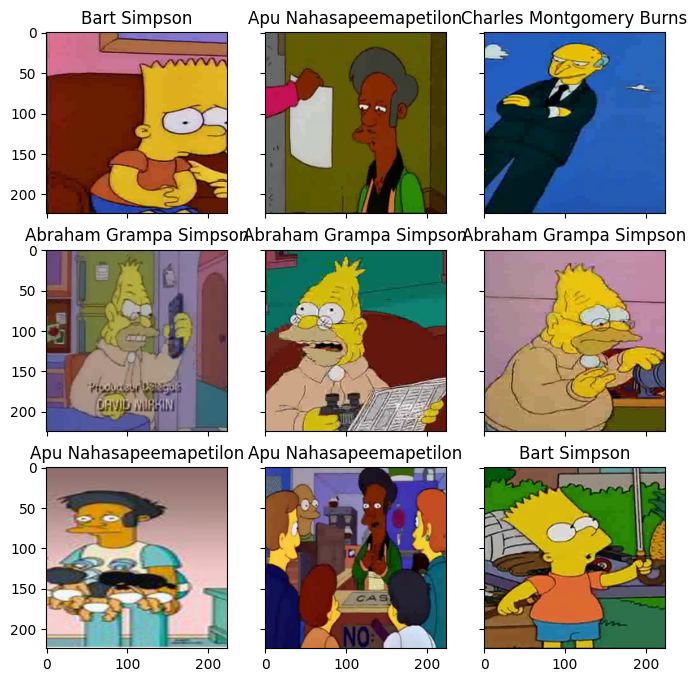

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [13]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8), # add batchnorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16), # add batchnorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), # add batchnorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), # add batchnorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96), # add batchnorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [14]:
import copy
import torch
from torch.amp import autocast, GradScaler

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer, scaler, kornia_transform=None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Аугментации на GPU
        if kornia_transform:
            inputs = kornia_transform(inputs)

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
import kornia.augmentation as K

def train(train_dataset, val_dataset, model, epochs, batch_size, logdir):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    writer = SummaryWriter(log_dir=logdir)
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    scaler = GradScaler()

    # делаем аугментации здесь на gpu чтобы было быстрее
    kornia_transform = torch.nn.Sequential(
        K.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        K.ColorJitter(0.2, 0.2, 0.2, 0.1),
        K.RandomHorizontalFlip(p=0.5)
    ).to(DEVICE)

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scaler, kornia_transform)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Accuracy/val", val_acc, epoch)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "./simpsons_logs/best_model.pt")

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history


In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Обучение проходило на локальной машине в Visual Studio Code. Результаты сохранялись в ./simpsons_logs

В simpsons_logs будут находится папки с названием эксперимента и временем обучения, внутри этих папок сохранённые модели

In [20]:
from datetime import datetime
import os

LOGDIR = "./simpsons_logs"

In [21]:
def get_logdir(experiment_name="run"):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    full_logdir = os.path.join(LOGDIR, f"{experiment_name}_{timestamp}")
    os.makedirs(full_logdir, exist_ok=True)
    return full_logdir

In [22]:
%reload_ext tensorboard
%tensorboard --logdir "{LOGDIR}"

Запустим обучение сети.

In [185]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [186]:
logdir = get_logdir("simple_net")
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64, logdir=logdir)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

Построим кривые обучения

In [187]:
def train_val_plot(history):
  loss, acc, val_loss, val_acc = zip(*history)
  plt.figure(figsize=(4, 4))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

In [31]:
train_val_plot(history)

NameError: name 'history' is not defined

## Попробуем Transfer Learning
- Попробуем использовать ResNet как в семинаре

Варианты:
1. ResNet18, обучение классификатора, а после файнтюнинг: обучение всей сети, но с уменьшенным lr

In [36]:
models.resnet18(pretrained=True)

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
model_resnet = models.resnet18(pretrained=True)
model_resnet = model_resnet.to(DEVICE)

for param in model_resnet.parameters():
  param.requires_grad = False

num_feat = 512
model_resnet.fc = nn.Linear(512, 42)
model_resnet = model_resnet.to(DEVICE)

optimizer = torch.optim.AdamW(model_resnet.fc.parameters(), lr=1e-3)

Обучим без файнтюнинга: только с обученным классификатором

In [38]:
sum(p.numel() for p in model_resnet.fc.parameters() if p.requires_grad)

21546

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.560010766495534


epoch:  20%|██        | 1/5 [03:47<15:08, 227.16s/it]


Epoch 001 train_loss: 2.5600     val_loss 2.0335 train_acc 0.3242 val_acc 0.4973
loss 1.9045060100855513


epoch:  40%|████      | 2/5 [07:33<11:19, 226.54s/it]


Epoch 002 train_loss: 1.9045     val_loss 1.6935 train_acc 0.5108 val_acc 0.5759
loss 1.698375048960263


epoch:  60%|██████    | 3/5 [11:20<07:33, 226.84s/it]


Epoch 003 train_loss: 1.6984     val_loss 1.5369 train_acc 0.5484 val_acc 0.6015
loss 1.5535412077175081


epoch:  80%|████████  | 4/5 [15:08<03:47, 227.31s/it]


Epoch 004 train_loss: 1.5535     val_loss 1.4915 train_acc 0.5828 val_acc 0.6034
loss 1.4933039281040068


epoch: 100%|██████████| 5/5 [18:54<00:00, 226.90s/it]


Epoch 005 train_loss: 1.4933     val_loss 1.4088 train_acc 0.5918 val_acc 0.6284


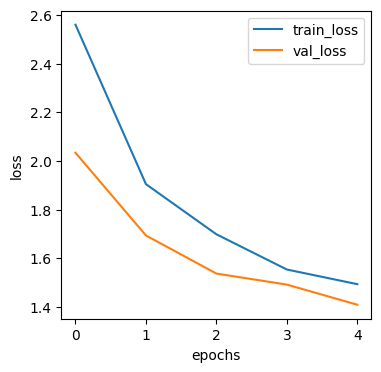

In [35]:
logdir = get_logdir("resnet_freeze_ep5_bs64")
history = train(train_dataset, val_dataset, model=model_resnet, epochs=5, batch_size=64, logdir=logdir)
train_val_plot(history)

Теперь немного дообучим несколько последних слоёв resnet и fc

In [36]:
model_freeze = copy.deepcopy(model_resnet)

In [37]:
# разморозка весов
for param in model_freeze.layer4.parameters():
    param.requires_grad = True
for param in model_freeze.fc.parameters():
    param.requires_grad = True

# Заморозим батч норм потому что нормализация уже настроена на нормальном датасете, и мы не хотим портить хорошие параметры нормализации
for module in model_freeze.modules():
  if isinstance(module, nn.BatchNorm2d):
      module.eval()

In [38]:
fc_params = list(model_freeze.fc.parameters())
layer4_params = list(model_freeze.layer4.parameters())

optimizer = torch.optim.Adam([
    {"params": layer4_params, "lr": 1e-5},
    {"params": fc_params, "lr": 1e-4},
], weight_decay=1e-4)

# optimizer = torch.optim.AdamW(model_freeze.parameters(), lr=1e-4)

In [39]:
model_freeze1 = copy.deepcopy(model_freeze)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.6039187051633474


epoch:  20%|██        | 1/5 [03:49<15:19, 229.92s/it]


Epoch 001 train_loss: 3.6039     val_loss 3.1052 train_acc 0.0950 val_acc 0.1074
loss 3.061844412601179


epoch:  40%|████      | 2/5 [07:37<11:26, 228.80s/it]


Epoch 002 train_loss: 3.0618     val_loss 3.3830 train_acc 0.1148 val_acc 0.1043
loss 2.8258651568863953


epoch:  60%|██████    | 3/5 [11:27<07:38, 229.11s/it]


Epoch 003 train_loss: 2.8259     val_loss 2.5934 train_acc 0.1772 val_acc 0.2564
loss 2.5083814591114306


epoch:  80%|████████  | 4/5 [15:43<03:59, 239.73s/it]


Epoch 004 train_loss: 2.5084     val_loss 2.1824 train_acc 0.2707 val_acc 0.3743
loss 2.0522786458287774


epoch: 100%|██████████| 5/5 [19:32<00:00, 234.57s/it]


Epoch 005 train_loss: 2.0523     val_loss 1.5564 train_acc 0.4116 val_acc 0.5655


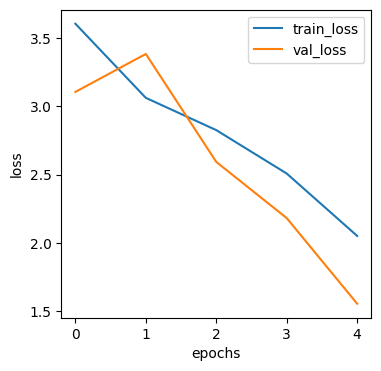

In [40]:
logdir = get_logdir("resnet_finetuned_ep5_bs64")
history = train(train_dataset, val_dataset, model=model_freeze1, epochs=5, batch_size=64, logdir=logdir)
train_val_plot(history)

In [41]:
model_freeze2 = copy.deepcopy(model_freeze)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 3.5053382375163027


epoch:   3%|▎         | 1/30 [03:48<1:50:30, 228.66s/it]


Epoch 001 train_loss: 3.5053     val_loss 3.1117 train_acc 0.1012 val_acc 0.1074
loss 3.1274338663516588


epoch:   7%|▋         | 2/30 [07:32<1:45:22, 225.82s/it]


Epoch 002 train_loss: 3.1274     val_loss 3.1147 train_acc 0.1052 val_acc 0.1074
loss 3.1018487375339463


epoch:  10%|█         | 3/30 [11:17<1:41:29, 225.56s/it]


Epoch 003 train_loss: 3.1018     val_loss 3.0169 train_acc 0.1117 val_acc 0.1494
loss 2.864753088895527


epoch:  13%|█▎        | 4/30 [15:03<1:37:49, 225.76s/it]


Epoch 004 train_loss: 2.8648     val_loss 2.6191 train_acc 0.1673 val_acc 0.2209
loss 2.390560189085604


epoch:  17%|█▋        | 5/30 [18:54<1:34:45, 227.43s/it]


Epoch 005 train_loss: 2.3906     val_loss 1.9700 train_acc 0.2829 val_acc 0.4215
loss 1.7940612905336357


epoch:  20%|██        | 6/30 [22:41<1:30:58, 227.46s/it]


Epoch 006 train_loss: 1.7941     val_loss 1.3552 train_acc 0.4849 val_acc 0.6227
loss 1.2547197130441863


epoch:  23%|██▎       | 7/30 [26:28<1:27:02, 227.09s/it]


Epoch 007 train_loss: 1.2547     val_loss 0.8885 train_acc 0.6676 val_acc 0.7619
loss 0.9505847704866919


epoch:  27%|██▋       | 8/30 [30:14<1:23:13, 226.97s/it]


Epoch 008 train_loss: 0.9506     val_loss 0.6894 train_acc 0.7523 val_acc 0.8166
loss 0.7715983911945347


epoch:  30%|███       | 9/30 [34:01<1:19:24, 226.89s/it]


Epoch 009 train_loss: 0.7716     val_loss 0.5986 train_acc 0.7978 val_acc 0.8370
loss 0.6769483173126642


epoch:  33%|███▎      | 10/30 [37:47<1:15:34, 226.71s/it]


Epoch 010 train_loss: 0.6769     val_loss 0.5254 train_acc 0.8211 val_acc 0.8559
loss 0.5876967873996409


epoch:  37%|███▋      | 11/30 [41:34<1:11:47, 226.73s/it]


Epoch 011 train_loss: 0.5877     val_loss 0.4880 train_acc 0.8432 val_acc 0.8724
loss 0.5431533935839025


epoch:  40%|████      | 12/30 [45:20<1:07:55, 226.44s/it]


Epoch 012 train_loss: 0.5432     val_loss 0.5590 train_acc 0.8569 val_acc 0.8626
loss 0.4987724810635575


epoch:  43%|████▎     | 13/30 [49:06<1:04:10, 226.50s/it]


Epoch 013 train_loss: 0.4988     val_loss 0.4363 train_acc 0.8657 val_acc 0.8842
loss 0.4641057100028124


epoch:  47%|████▋     | 14/30 [52:53<1:00:25, 226.58s/it]


Epoch 014 train_loss: 0.4641     val_loss 0.4278 train_acc 0.8755 val_acc 0.8871
loss 0.4406103053907884


epoch:  50%|█████     | 15/30 [56:40<56:37, 226.49s/it]  


Epoch 015 train_loss: 0.4406     val_loss 0.4083 train_acc 0.8805 val_acc 0.8964
loss 0.4079258383000016


epoch:  53%|█████▎    | 16/30 [1:00:26<52:50, 226.50s/it]


Epoch 016 train_loss: 0.4079     val_loss 0.3479 train_acc 0.8921 val_acc 0.9140
loss 0.386321291224016


epoch:  57%|█████▋    | 17/30 [1:04:12<49:01, 226.29s/it]


Epoch 017 train_loss: 0.3863     val_loss 0.3819 train_acc 0.8962 val_acc 0.9037
loss 0.3793996753635828


epoch:  60%|██████    | 18/30 [1:07:58<45:16, 226.40s/it]


Epoch 018 train_loss: 0.3794     val_loss 0.3083 train_acc 0.8998 val_acc 0.9253
loss 0.35361321663141204


epoch:  63%|██████▎   | 19/30 [1:11:45<41:32, 226.58s/it]


Epoch 019 train_loss: 0.3536     val_loss 0.3330 train_acc 0.9042 val_acc 0.9192
loss 0.3287830069377336


epoch:  67%|██████▋   | 20/30 [1:15:32<37:46, 226.69s/it]


Epoch 020 train_loss: 0.3288     val_loss 0.3363 train_acc 0.9122 val_acc 0.9136
loss 0.32336920305433503


epoch:  70%|███████   | 21/30 [1:19:19<34:00, 226.76s/it]


Epoch 021 train_loss: 0.3234     val_loss 0.3108 train_acc 0.9120 val_acc 0.9236
loss 0.297869920567332


epoch:  73%|███████▎  | 22/30 [1:23:06<30:14, 226.76s/it]


Epoch 022 train_loss: 0.2979     val_loss 0.2929 train_acc 0.9182 val_acc 0.9291
loss 0.30948406322927746


epoch:  77%|███████▋  | 23/30 [1:26:53<26:26, 226.70s/it]


Epoch 023 train_loss: 0.3095     val_loss 0.2988 train_acc 0.9159 val_acc 0.9312
loss 0.28414008380713845


epoch:  80%|████████  | 24/30 [1:30:39<22:40, 226.70s/it]


Epoch 024 train_loss: 0.2841     val_loss 0.3261 train_acc 0.9227 val_acc 0.9257
loss 0.27819936576485826


epoch:  83%|████████▎ | 25/30 [1:34:25<18:51, 226.31s/it]


Epoch 025 train_loss: 0.2782     val_loss 0.3428 train_acc 0.9229 val_acc 0.9268
loss 0.25845729491081776


epoch:  87%|████████▋ | 26/30 [1:38:12<15:06, 226.52s/it]


Epoch 026 train_loss: 0.2585     val_loss 0.3113 train_acc 0.9280 val_acc 0.9291
loss 0.2704300697403128


epoch:  90%|█████████ | 27/30 [1:41:58<11:19, 226.39s/it]


Epoch 027 train_loss: 0.2704     val_loss 0.3369 train_acc 0.9273 val_acc 0.9234
loss 0.25646591470138125


epoch:  93%|█████████▎| 28/30 [1:45:45<07:33, 226.62s/it]


Epoch 028 train_loss: 0.2565     val_loss 0.3343 train_acc 0.9288 val_acc 0.9253
loss 0.24651337598076564


epoch:  97%|█████████▋| 29/30 [1:49:31<03:46, 226.52s/it]


Epoch 029 train_loss: 0.2465     val_loss 0.3160 train_acc 0.9312 val_acc 0.9255
loss 0.22989926373353392


epoch: 100%|██████████| 30/30 [1:53:18<00:00, 226.62s/it]


Epoch 030 train_loss: 0.2299     val_loss 0.3287 train_acc 0.9383 val_acc 0.9251


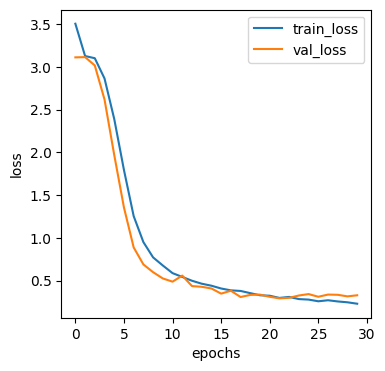

In [42]:
logdir = get_logdir("resnet_finetuned_ep30_bs64")
history = train(train_dataset, val_dataset, model=model_freeze2, epochs=30, batch_size=64, logdir=logdir)
train_val_plot(history)

In [43]:
model_freeze3 = copy.deepcopy(model_freeze)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 4.280661918379044


epoch:   2%|▎         | 1/40 [03:30<2:16:56, 210.67s/it]


Epoch 001 train_loss: 4.2807     val_loss 3.1003 train_acc 0.0892 val_acc 0.1074
loss 3.0583027854331157


epoch:   5%|▌         | 2/40 [07:00<2:13:03, 210.09s/it]


Epoch 002 train_loss: 3.0583     val_loss 2.9482 train_acc 0.1248 val_acc 0.1528
loss 2.7868304298185103


epoch:   8%|▊         | 3/40 [10:30<2:09:34, 210.11s/it]


Epoch 003 train_loss: 2.7868     val_loss 2.5111 train_acc 0.1947 val_acc 0.2835
loss 2.436981396125649


epoch:  10%|█         | 4/40 [14:00<2:06:07, 210.20s/it]


Epoch 004 train_loss: 2.4370     val_loss 2.1036 train_acc 0.3005 val_acc 0.4043
loss 2.0537150558130524


epoch:  12%|█▎        | 5/40 [17:29<2:02:23, 209.81s/it]


Epoch 005 train_loss: 2.0537     val_loss 1.8328 train_acc 0.4135 val_acc 0.4824
loss 1.7101096685877788


epoch:  15%|█▌        | 6/40 [20:59<1:58:50, 209.71s/it]


Epoch 006 train_loss: 1.7101     val_loss 1.3897 train_acc 0.5269 val_acc 0.6360
loss 1.3983044994280622


epoch:  18%|█▊        | 7/40 [24:29<1:55:18, 209.66s/it]


Epoch 007 train_loss: 1.3983     val_loss 1.1097 train_acc 0.6274 val_acc 0.7125
loss 1.101320382781648


epoch:  20%|██        | 8/40 [27:59<1:51:57, 209.91s/it]


Epoch 008 train_loss: 1.1013     val_loss 0.8526 train_acc 0.7082 val_acc 0.7770
loss 0.9431569093093347


epoch:  22%|██▎       | 9/40 [31:29<1:48:25, 209.85s/it]


Epoch 009 train_loss: 0.9432     val_loss 0.7549 train_acc 0.7479 val_acc 0.8015
loss 0.8411891935160072


epoch:  25%|██▌       | 10/40 [34:59<1:44:58, 209.96s/it]


Epoch 010 train_loss: 0.8412     val_loss 0.6284 train_acc 0.7783 val_acc 0.8380
loss 0.7578741098499668


epoch:  28%|██▊       | 11/40 [38:28<1:41:21, 209.72s/it]


Epoch 011 train_loss: 0.7579     val_loss 0.5992 train_acc 0.8001 val_acc 0.8426
loss 0.6690021250815792


epoch:  30%|███       | 12/40 [41:58<1:37:53, 209.76s/it]


Epoch 012 train_loss: 0.6690     val_loss 0.5134 train_acc 0.8253 val_acc 0.8670
loss 0.5847829865364446


epoch:  32%|███▎      | 13/40 [45:28<1:34:22, 209.70s/it]


Epoch 013 train_loss: 0.5848     val_loss 0.4775 train_acc 0.8446 val_acc 0.8722
loss 0.5442703658740637


epoch:  35%|███▌      | 14/40 [48:56<1:30:42, 209.34s/it]


Epoch 014 train_loss: 0.5443     val_loss 0.4697 train_acc 0.8562 val_acc 0.8724
loss 0.5091719165585802


epoch:  38%|███▊      | 15/40 [52:25<1:27:10, 209.21s/it]


Epoch 015 train_loss: 0.5092     val_loss 0.4985 train_acc 0.8643 val_acc 0.8728
loss 0.48774456195910576


epoch:  40%|████      | 16/40 [55:55<1:23:46, 209.43s/it]


Epoch 016 train_loss: 0.4877     val_loss 0.3866 train_acc 0.8683 val_acc 0.9003
loss 0.4579650549985351


epoch:  42%|████▎     | 17/40 [59:25<1:20:22, 209.67s/it]


Epoch 017 train_loss: 0.4580     val_loss 0.4145 train_acc 0.8790 val_acc 0.8909
loss 0.4268700219759615


epoch:  45%|████▌     | 18/40 [1:02:55<1:16:53, 209.70s/it]


Epoch 018 train_loss: 0.4269     val_loss 0.3875 train_acc 0.8882 val_acc 0.9008
loss 0.4014072814086978


epoch:  48%|████▊     | 19/40 [1:06:25<1:13:27, 209.90s/it]


Epoch 019 train_loss: 0.4014     val_loss 0.3722 train_acc 0.8925 val_acc 0.9049
loss 0.4078335242054175


epoch:  50%|█████     | 20/40 [1:09:55<1:09:59, 209.97s/it]


Epoch 020 train_loss: 0.4078     val_loss 0.3529 train_acc 0.8879 val_acc 0.9089
loss 0.3688375309980085


epoch:  52%|█████▎    | 21/40 [1:13:25<1:06:29, 209.96s/it]


Epoch 021 train_loss: 0.3688     val_loss 0.3221 train_acc 0.8994 val_acc 0.9192
loss 0.352408293770623


epoch:  55%|█████▌    | 22/40 [1:16:55<1:02:59, 209.99s/it]


Epoch 022 train_loss: 0.3524     val_loss 0.3354 train_acc 0.9025 val_acc 0.9135
loss 0.3383726721448089


epoch:  57%|█████▊    | 23/40 [1:20:25<59:29, 209.95s/it]  


Epoch 023 train_loss: 0.3384     val_loss 0.3662 train_acc 0.9094 val_acc 0.9089
loss 0.3452375551015452


epoch:  60%|██████    | 24/40 [1:23:54<55:55, 209.71s/it]


Epoch 024 train_loss: 0.3452     val_loss 0.3477 train_acc 0.9050 val_acc 0.9098
loss 0.2973401458071739


epoch:  62%|██████▎   | 25/40 [1:27:24<52:26, 209.75s/it]


Epoch 025 train_loss: 0.2973     val_loss 0.3120 train_acc 0.9169 val_acc 0.9217
loss 0.30672098963805405


epoch:  65%|██████▌   | 26/40 [1:30:53<48:53, 209.53s/it]


Epoch 026 train_loss: 0.3067     val_loss 0.3395 train_acc 0.9146 val_acc 0.9240
loss 0.29001493446461996


epoch:  68%|██████▊   | 27/40 [1:34:23<45:23, 209.53s/it]


Epoch 027 train_loss: 0.2900     val_loss 0.3384 train_acc 0.9207 val_acc 0.9263
loss 0.27889254418320925


epoch:  70%|███████   | 28/40 [1:37:53<41:56, 209.73s/it]


Epoch 028 train_loss: 0.2789     val_loss 0.3026 train_acc 0.9218 val_acc 0.9284
loss 0.2699638825640556


epoch:  72%|███████▎  | 29/40 [1:41:24<38:29, 209.98s/it]


Epoch 029 train_loss: 0.2700     val_loss 0.3079 train_acc 0.9267 val_acc 0.9308
loss 0.253335070219744


epoch:  75%|███████▌  | 30/40 [1:44:54<35:00, 210.08s/it]


Epoch 030 train_loss: 0.2533     val_loss 0.3369 train_acc 0.9311 val_acc 0.9224
loss 0.2574827224841975


epoch:  78%|███████▊  | 31/40 [1:48:30<31:46, 211.81s/it]


Epoch 031 train_loss: 0.2575     val_loss 0.2956 train_acc 0.9287 val_acc 0.9293
loss 0.23947484510132017


epoch:  80%|████████  | 32/40 [1:52:00<28:11, 211.47s/it]


Epoch 032 train_loss: 0.2395     val_loss 0.2723 train_acc 0.9339 val_acc 0.9391
loss 0.24798926499605375


epoch:  82%|████████▎ | 33/40 [1:55:31<24:38, 211.25s/it]


Epoch 033 train_loss: 0.2480     val_loss 0.3448 train_acc 0.9345 val_acc 0.9182
loss 0.2266579735156829


epoch:  85%|████████▌ | 34/40 [1:59:01<21:05, 210.98s/it]


Epoch 034 train_loss: 0.2267     val_loss 0.2991 train_acc 0.9361 val_acc 0.9324
loss 0.2236403831574361


epoch:  88%|████████▊ | 35/40 [2:02:31<17:32, 210.44s/it]


Epoch 035 train_loss: 0.2236     val_loss 0.3182 train_acc 0.9369 val_acc 0.9249
loss 0.21757634069515008


epoch:  90%|█████████ | 36/40 [2:06:01<14:02, 210.56s/it]


Epoch 036 train_loss: 0.2176     val_loss 0.3290 train_acc 0.9401 val_acc 0.9284
loss 0.21959401387727231


epoch:  92%|█████████▎| 37/40 [2:09:33<10:32, 210.78s/it]


Epoch 037 train_loss: 0.2196     val_loss 0.3286 train_acc 0.9406 val_acc 0.9232
loss 0.20346752974332324


epoch:  95%|█████████▌| 38/40 [2:13:03<07:01, 210.74s/it]


Epoch 038 train_loss: 0.2035     val_loss 0.3037 train_acc 0.9427 val_acc 0.9366
loss 0.19888898385726037


epoch:  98%|█████████▊| 39/40 [2:16:34<03:30, 210.56s/it]


Epoch 039 train_loss: 0.1989     val_loss 0.3135 train_acc 0.9433 val_acc 0.9247
loss 0.19073766930497096


epoch: 100%|██████████| 40/40 [2:20:04<00:00, 210.11s/it]


Epoch 040 train_loss: 0.1907     val_loss 0.3320 train_acc 0.9473 val_acc 0.9297


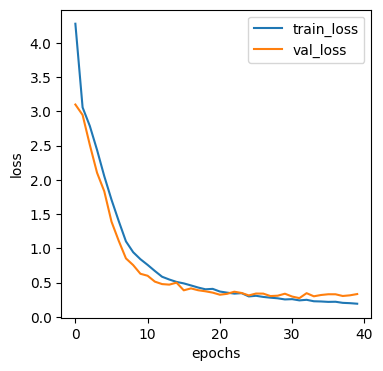

In [44]:
logdir = get_logdir("resnet_finetuned_ep40_bs128")
history = train(train_dataset, val_dataset, model=model_freeze3, epochs=40, batch_size=128, logdir=logdir)
train_val_plot(history)

2. Inception. Обучим fc на lr=1e-4, затем обучим последние Mixed 7b, 7c и fc слои на lr=1e-6

In [31]:
models.inception_v3()

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [31]:
class InceptionFinetuned(torch.nn.Module):
    def __init__(self):
        super().__init__()
        base = models.inception_v3(aux_logits=False, transform_input=False)
        self.features = base
        self.features.fc = nn.Identity()
        self.fc = nn.Linear(2048,42)
        
    def freeze(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def unfreeze_fc(self):
        for param in self.fc.parameters():
            param.requires_grad = True
    def unfreeze_mixed7(self):
        for name in ['Mixed_7a', 'Mixed_7b', 'Mixed_7c']:
            for param in getattr(self.features, name).parameters():
                param.requires_grad = True
                
    def freeze_batchnorm(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                
    def getTrainingConvParams(self):
        params = []
        for name in ['Mixed_7a', 'Mixed_7b', 'Mixed_7c']:
            params += list(getattr(self.features, name).parameters())
        return params
    
    def getFCParams(self):
        return list(self.fc.parameters())
    
    def move_to_device(self, device):
        return self.to(device)
        
    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

In [32]:
model_inception = InceptionFinetuned()
model_inception.freeze()
model_inception.unfreeze_fc()
model_inception.move_to_device(DEVICE)

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


InceptionFinetuned(
  (features): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3

In [33]:
optimizer = torch.optim.AdamW(model_inception.fc.parameters(), lr=1e-3)

In [34]:
sum(p.numel() for p in model_inception.fc.parameters() if p.requires_grad)

86058

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.1853061400444553


epoch:  20%|██        | 1/5 [04:37<18:30, 277.58s/it]


Epoch 001 train_loss: 3.1853     val_loss 3.0223 train_acc 0.1024 val_acc 0.1446
loss 3.105030648943284


epoch:  40%|████      | 2/5 [08:50<13:08, 263.00s/it]


Epoch 002 train_loss: 3.1050     val_loss 2.9510 train_acc 0.1214 val_acc 0.1592
loss 3.065766996392415


epoch:  60%|██████    | 3/5 [12:42<08:18, 249.07s/it]


Epoch 003 train_loss: 3.0658     val_loss 2.9137 train_acc 0.1321 val_acc 0.1679
loss 3.039390260257936


epoch:  80%|████████  | 4/5 [16:47<04:07, 247.38s/it]


Epoch 004 train_loss: 3.0394     val_loss 2.8715 train_acc 0.1377 val_acc 0.2002
loss 3.030298366038782


epoch: 100%|██████████| 5/5 [20:27<00:00, 245.42s/it]


Epoch 005 train_loss: 3.0303     val_loss 2.8499 train_acc 0.1449 val_acc 0.1993


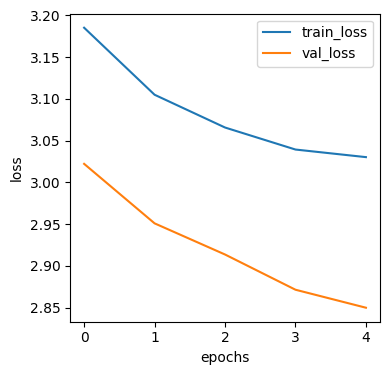

In [35]:
logdir = get_logdir("inception_fc_ep5_bs64")
history = train(train_dataset, val_dataset, model=model_inception, epochs=5, batch_size=64, logdir=logdir)
train_val_plot(history)

In [188]:
model_inception.unfreeze_mixed7()
model_inception.freeze_batchnorm()

In [189]:
optimizer = torch.optim.Adam([
    {"params": model_inception.getTrainingConvParams(), "lr": 1e-5},
    {"params": model_inception.getFCParams(), "lr": 1e-4},
], weight_decay=1e-4)

In [190]:
model_inception_bs64 = copy.deepcopy(model_inception).to(DEVICE)
model_inception_bs128 = copy.deepcopy(model_inception).to(DEVICE)

In [191]:
logdir = get_logdir("inception_finetuned_ep25_bs64")
history = train(train_dataset, val_dataset, model=model_inception_bs64, epochs=25, batch_size=64, logdir=logdir)
train_val_plot(history)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 2.889240710247367


epoch:   4%|▍         | 1/25 [02:51<1:08:38, 171.61s/it]


Epoch 001 train_loss: 2.8892     val_loss 96.1564 train_acc 0.2103 val_acc 0.0864
loss 2.591915154807909


epoch:   8%|▊         | 2/25 [05:50<1:07:21, 175.71s/it]


Epoch 002 train_loss: 2.5919     val_loss 37.3813 train_acc 0.2829 val_acc 0.0751
loss 2.398586739566768


epoch:  12%|█▏        | 3/25 [08:28<1:01:30, 167.76s/it]


Epoch 003 train_loss: 2.3986     val_loss 52.9050 train_acc 0.3389 val_acc 0.0063
loss 2.2966929742717253


epoch:  16%|█▌        | 4/25 [10:50<55:12, 157.75s/it]  


Epoch 004 train_loss: 2.2967     val_loss 41.3936 train_acc 0.3619 val_acc 0.0695
loss 2.1876079952787446


epoch:  20%|██        | 5/25 [13:09<50:13, 150.67s/it]


Epoch 005 train_loss: 2.1876     val_loss 25.1074 train_acc 0.3900 val_acc 0.0573
loss 2.103640087896627


epoch:  24%|██▍       | 6/25 [15:31<46:48, 147.81s/it]


Epoch 006 train_loss: 2.1036     val_loss 27.8325 train_acc 0.4158 val_acc 0.0575
loss 2.041254785867457


epoch:  28%|██▊       | 7/25 [17:49<43:23, 144.65s/it]


Epoch 007 train_loss: 2.0413     val_loss 20.0103 train_acc 0.4302 val_acc 0.0655
loss 1.9979591346544874


epoch:  32%|███▏      | 8/25 [20:07<40:25, 142.69s/it]


Epoch 008 train_loss: 1.9980     val_loss 18.7567 train_acc 0.4410 val_acc 0.0883
loss 1.9358634413089773


epoch:  36%|███▌      | 9/25 [22:25<37:39, 141.23s/it]


Epoch 009 train_loss: 1.9359     val_loss 24.5795 train_acc 0.4593 val_acc 0.0455
loss 1.9081701352737672


epoch:  40%|████      | 10/25 [24:43<35:00, 140.05s/it]


Epoch 010 train_loss: 1.9082     val_loss 14.6007 train_acc 0.4662 val_acc 0.0856
loss 1.8735656860003966


epoch:  44%|████▍     | 11/25 [27:00<32:29, 139.23s/it]


Epoch 011 train_loss: 1.8736     val_loss 24.1697 train_acc 0.4773 val_acc 0.0577
loss 1.8254060785408512


epoch:  48%|████▊     | 12/25 [29:18<30:04, 138.80s/it]


Epoch 012 train_loss: 1.8254     val_loss 10.3845 train_acc 0.4910 val_acc 0.1045
loss 1.799904619973893


epoch:  52%|█████▏    | 13/25 [31:36<27:42, 138.52s/it]


Epoch 013 train_loss: 1.7999     val_loss 29.4125 train_acc 0.4976 val_acc 0.0839


epoch:  52%|█████▏    | 13/25 [32:12<29:43, 148.63s/it]


KeyboardInterrupt: 

In [ ]:
logdir = get_logdir("inception_finetuned_ep30_bs128")
history = train(train_dataset, val_dataset, model=model_inception_bs128, epochs=30, batch_size=128, logdir=logdir)
train_val_plot(history)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [42]:
best_model = models.resnet18(pretrained=True)
best_model = best_model.to(DEVICE)

num_feat = 512
best_model.fc = nn.Linear(num_feat, 42)
best_model = best_model.to(DEVICE)
best_model.load_state_dict(torch.load("simpsons_logs/best_model.pt"))

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22756\2652843826.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/

<All keys matched successfully>

In [43]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [44]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(best_model, ex_img.unsqueeze(0))

In [50]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(best_model, imgs)

In [51]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [52]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [53]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.95


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

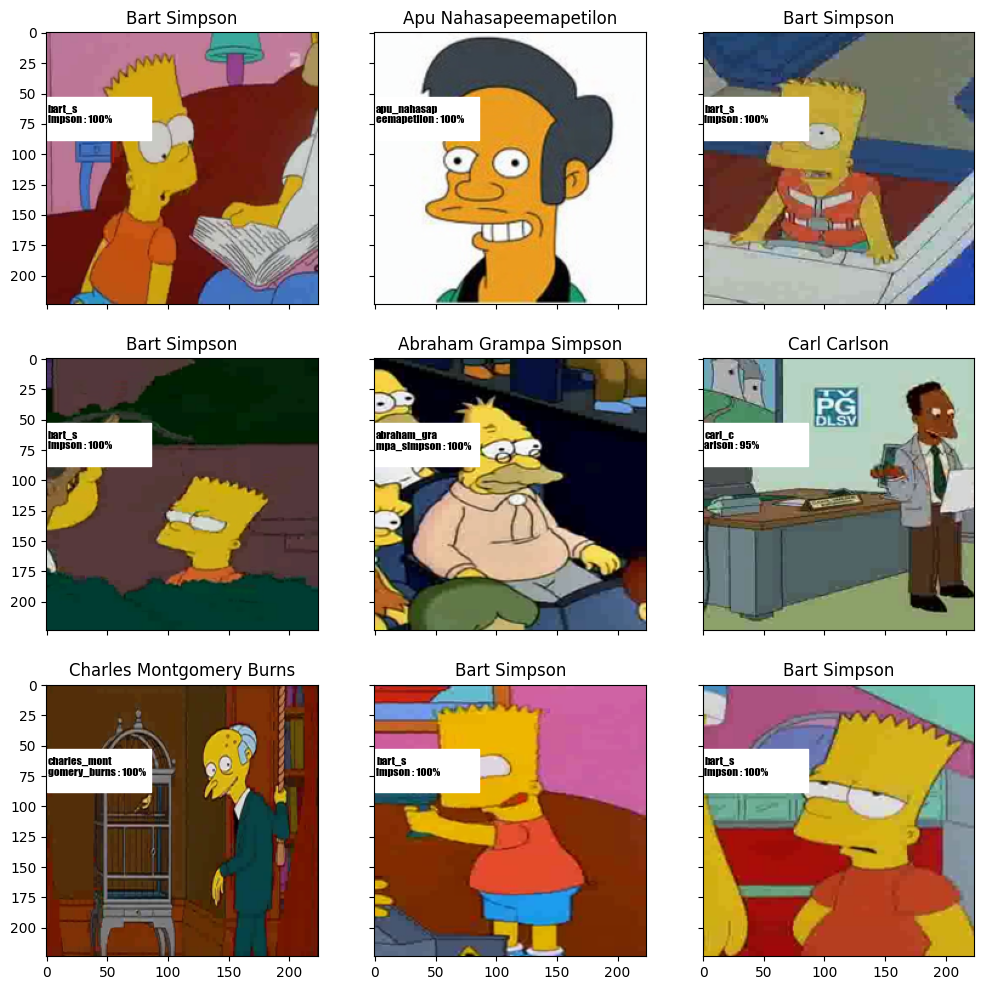

In [56]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(best_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [68]:
len(preds), len(test_filenames)

(991, 991)

In [70]:
import pandas as pd
test_filenames_df = pd.DataFrame(test_filenames, columns=['Id'])
preds_df = pd.DataFrame(preds, columns=['Expected'])
my_submit = pd.concat([test_filenames_df, preds_df], axis=1)
my_submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,homer_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [71]:
my_submit.to_csv('my_submission.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## Изменения и история
Что я поменял:

1.
- Аугментация:
```python
  if (self.mode == 'train'):
    transform = transforms.Compose([
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(), # в numpy: HWC в CHW
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(), # в numpy: HWC в CHW
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
```
- Batchnorm

Итог: Epoch 005 train_loss: 1.0823     val_loss 0.8049 train_acc 0.7015 val_acc 0.7742

2.
-